In [1]:
import os
import pickle

from PIL import Image, ImageDraw

import numpy as np
import scipy.integrate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from einops import repeat, rearrange
from tqdm.notebook import tqdm

In [2]:
plt.style.use("seaborn")
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
def subsample_min_dist(t, n, min_dist):
    """Subsamples `n` time points from `t`.
    Ensures that the minimum distance between any point and its closest neighbor is `min_dist`.
    """
    assert n <= len(t), "Too large `n`."
    assert min_dist <= (t.max() - t.min()) / (n - 1), "Too large `min_dist`."
    inds = [0, len(t)-1]
    for i in range(n-2):
        c, c_max = 0, 1e4
        while True:
            ind_i = np.random.choice(len(t), size=1)
            dists = np.abs(t[inds] - t[ind_i])
            if np.min(dists) >= min_dist:
                inds.append(ind_i.item())
                break
            if c > c_max:
                raise RuntimeError("Failed to subsample the time grid. Use smalled `n` or `min_dist`.")
            c += 1
    return t[sorted(inds)]


def generate_irregular_time_grid(T, M, min_dist, seed=None):
    if seed is not None:
        np.random.seed(seed)
    t = np.linspace(0, T, 100*M)
    t = subsample_min_dist(t, M, min_dist)
    return t


class PendulumDrawer():
    def __init__(self, img_width, img_height, pendulum_width, pendulum_length) -> None:
        self.img_width = img_width
        self.img_height = img_height
        self.pendulum_width = pendulum_width
        self.pendulum_length = pendulum_length

    def get_image(self, angle):
        """Returns ndarray representing image of pendulum."""
        x_a = (self.img_width//2, self.img_height//2)
        x_b = (self.img_width//2, self.img_height//2 + self.pendulum_length)
        image = Image.new("L", (self.img_width, self.img_height), (0))
        ImageDraw.Draw(image).line([x_a, x_b], fill="white", width=self.pendulum_width)
        image = image.rotate(angle, resample=Image.BICUBIC)
        return np.array(image)
    

class PendulumSimulator():
    def __init__(self) -> None:
        self.m = 1
        self.g = 9.81
        self.length = 1.0
        self.b = 0

    def simulate(self, z0, t):
        """Takes initial condition z0 (ndarray of length 2, z[0] is angle, 
            z[1] is angular velocity) and time t (ndarray of length M) and outputs 
            ndarray of length M with the angle at the time points t. All the angles are in radians."""
        
        def dynamics(t, z):
            dzdt = np.array(
                [
                    z[1], 
                    -self.g / self.length * np.sin(z[0]) - self.b / self.m * z[1]
                ]
            )
            return dzdt

        z = scipy.integrate.solve_ivp(
            dynamics, (t[0], t[-1]), z0, method="RK45", rtol=1e-5, atol=1e-5, t_eval=t).y.T
        return z


def pickle_data(data_dict: dict[str, list], path: str ="./") -> None:
    if not os.path.isdir(path):
        os.makedirs(path)
    for name, data in data_dict.items():
        with open(path+name+".pkl", "wb") as f:
            pickle.dump(data, f, protocol=4)


def read_pickle(keys: list[str], path: str = "./") -> dict[str, list]:
    data_dict = {}
    for key in keys:
        with open(path+key+".pkl", "rb") as f:
            data_dict[key] = pickle.load(f)
    return data_dict


def generate_data(S, M, T, regular=True, seed=None):
    edge_dim = 32  # image size is (edge_dim x edge_dim)
    pend_sim = PendulumSimulator()
    pend_drawer = PendulumDrawer(edge_dim, edge_dim, int(0.1 * edge_dim), int(0.45 * edge_dim))

    if regular:
        t = np.linspace(0, T, M)
    else:
        t = generate_irregular_time_grid(T, M, min_dist=0.25*T/(M-1), seed=seed)
        # t = generate_irregular_time_grid(T, M, dt=T/(M-1), seed=seed)
    M = len(t)

    y = np.empty((S, M, 1, edge_dim**2), dtype=np.uint8)
    y_raw = np.empty((S, M, 1, 2), dtype=np.float32)
    
    if seed is not None:
        np.random.seed(seed)

    for i in range(S):
        z0 = np.array([
            2 * np.random.rand() * np.pi,
            2 * (np.random.rand() - 0.5) * (np.pi / 2),
        ])

        z = pend_sim.simulate(z0, t)

        y_raw[i, :, 0, :] = z / np.pi * 180  # radians to angles
        y_raw[i, :, 0, 0] %= 360

        # Generate images from angles theta.
        theta = y_raw[i, :, 0, 0]
        pend_imgs = np.stack([pend_drawer.get_image(theta_i) for theta_i in theta]).reshape(M, -1)
        y[i, :, 0, :] = pend_imgs

    return y, y_raw, t  # Shapes - y: (S, M, 1, edge_dim**2), y_raw: (S, M, 1, 2), t: (M, )

#### Generate Data

In [21]:
SEED = 1545

S = 500  # number of simulations
M = 51  # number of time points
T = 3.0  # terminal time
regular = True  # regular/irregular grid flag

y = []  # data (image)
y_raw = []  # raw data (angle and angular velocity)
t = []  # time grids

np.random.seed(SEED)
for i in tqdm(range(S), total=S):
    y_i, y_raw_i, t_i = generate_data(S=1, M=M, T=T, seed=SEED+i, regular=regular)
    y.append(y_i[0])
    y_raw.append(y_raw_i[0])
    t.append(t_i.reshape(-1, 1))

y_train, y_val, y_test = y[0:400], y[400:450], y[450:]
y_raw_train, y_raw_val, y_raw_test = y_raw[0:400], y_raw[400:450], y_raw[450:]
t_train, t_val, t_test = t[0:400], t[400:450], t[450:]

if regular:
    pickle_data({"t": t_train, "y": y_train, "y_raw": y_raw_train}, path=f"../datasets/pendulum_unif/train/")
    pickle_data({"t": t_val, "y": y_val, "y_raw": y_raw_val}, path=f"../datasets/pendulum_unif/val/")
    pickle_data({"t": t_test, "y": y_test, "y_raw": y_raw_test}, path=f"../datasets/pendulum_unif/test/")
else:
    pickle_data({"t": t_train, "y": y_train, "y_raw": y_raw_train}, path=f"../datasets/pendulum/train/")
    pickle_data({"t": t_val, "y": y_val, "y_raw": y_raw_val}, path=f"../datasets/pendulum/val/")
    pickle_data({"t": t_test, "y": y_test, "y_raw": y_raw_test}, path=f"../datasets/pendulum/test/")

  0%|          | 0/500 [00:00<?, ?it/s]

#### Look at the data

In [22]:
print(
    f"Minimum number of time points: {np.min([ti.shape[0] for ti in t])}\n"
    f"Maximum number of time points: {np.max([ti.shape[0] for ti in t])}\n\n"

    f"Minimum time: {np.min([ti[0, 0] for ti in t])}\n"
    f"Maximum time: {np.max([ti[-1, 0] for ti in t])}\n\n"

    f"Minimum temporal distance: {np.min([np.diff(ti.ravel()) for ti in t]):.3f}\n"
    f"Maximum temporal distance: {np.max([np.diff(ti.ravel()) for ti in t]):.3f}\n\n"

    f"Minimum angle: {np.min([yi[:, 0, 0].min() for yi in y_raw]):.1f}\n"
    f"Maximum angle: {np.max([yi[:, 0, 0].max() for yi in y_raw]):.1f}\n\n"

    f"Minimum angular velocity: {np.min([yi[:, 0, 1].min() for yi in y_raw]):.1f}\n"
    f"Maximum angular velocity: {np.max([yi[:, 0, 1].max() for yi in y_raw]):.1f}\n\n"
)

Minimum number of time points: 51
Maximum number of time points: 51

Minimum time: 0.0
Maximum time: 3.0

Minimum temporal distance: 0.060
Maximum temporal distance: 0.060

Minimum angle: 0.0
Maximum angle: 360.0

Minimum angular velocity: -369.1
Maximum angular velocity: 367.4




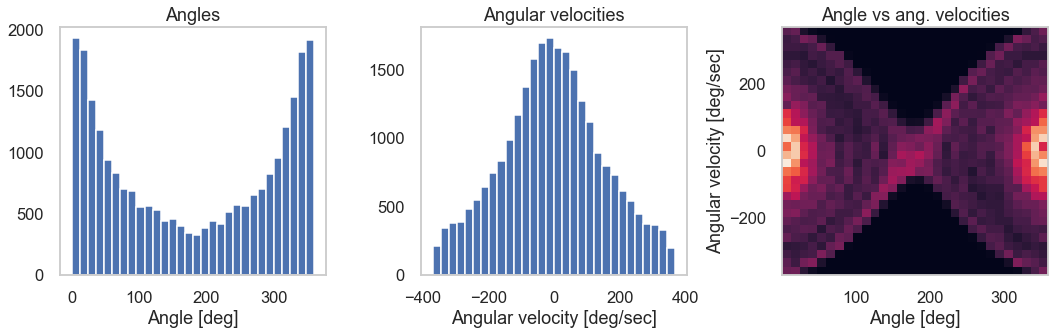

In [23]:
angles = np.concatenate([yi[:, 0, 0] for yi in y_raw])
angular_velocities = np.concatenate([yi[:, 0, 1] for yi in y_raw])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax[i].grid(False)

ax[0].hist(angles, bins=30)
ax[0].set_title("Angles")
ax[0].set_xlabel("Angle [deg]")

ax[1].hist(angular_velocities, bins=30)
ax[1].set_title("Angular velocities")
ax[1].set_xlabel("Angular velocity [deg/sec]")

ax[2].hist2d(angles, angular_velocities, bins=30)
ax[2].set_title("Angle vs ang. velocities")
ax[2].set_xlabel("Angle [deg]")
ax[2].set_ylabel("Angular velocity [deg/sec]")

fig.tight_layout()

plt.show()

Minimum number of time points before 0.450 sec.: 8
Minimum number of time points before 0.450 sec.: 8


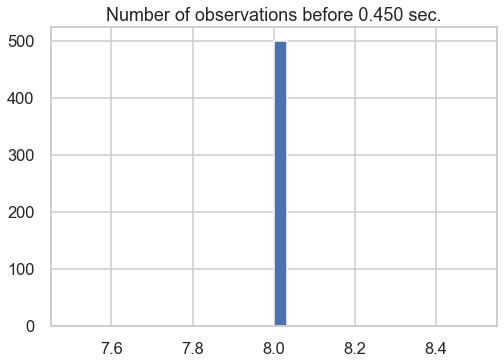

In [24]:
t_inf = 0.15 * T
t_inf_size = np.array([sum(ti.ravel() < t_inf) for ti in t])

print(
    f"Minimum number of time points before {t_inf:.3f} sec.: {np.min(t_inf_size)}\n"
    f"Minimum number of time points before {t_inf:.3f} sec.: {np.max(t_inf_size)}"
)

plt.hist(t_inf_size, bins=30)
plt.title(f"Number of observations before {t_inf:.3f} sec.")
plt.show()

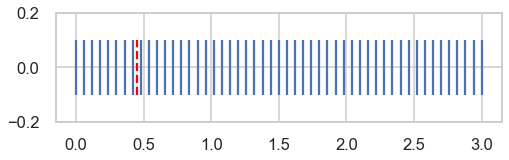

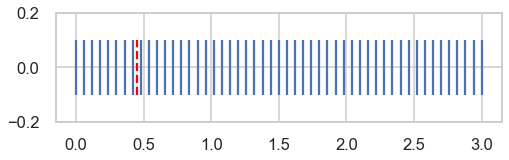

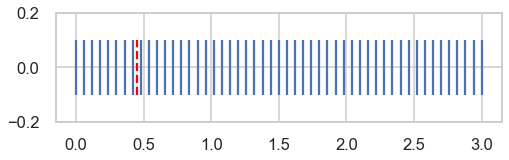

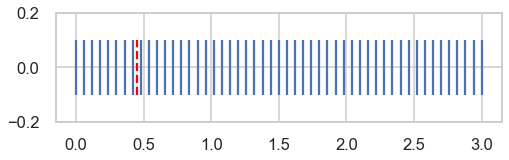

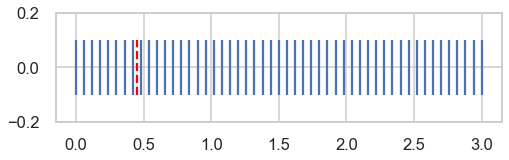

In [25]:
size = 8
inds_for_size = np.argwhere(t_inf_size == size).ravel()

for i in range(min(5, len(inds_for_size))):
    fig, ax = plt.subplots(1, 1, figsize=(8, 2))
    ax.vlines(t[inds_for_size[i]].ravel(), -0.1, 0.1)
    ax.vlines(t_inf, -0.1, 0.1, color="r", linestyle="--")
    ax.set_ylim(-0.2, 0.2)
    # ax.set_title(f"Time grid with {size} observations before {t_inf:.1f} sec. Index: {inds_for_size[i]}.")
    plt.show()

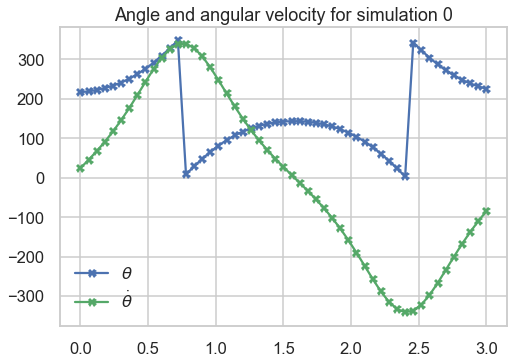

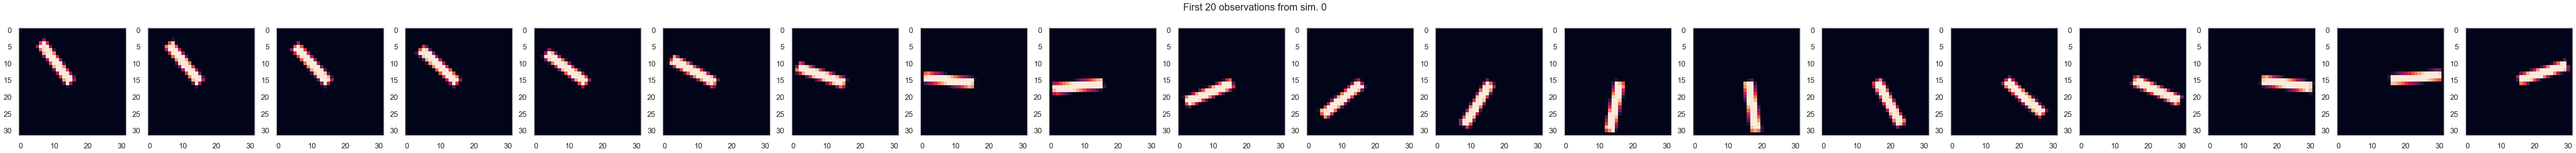

In [26]:
sim_ind = 0

plt.plot(t[sim_ind].ravel(), y_raw[sim_ind][:, 0, 0], "X-", label=r"$\theta$")
plt.plot(t[sim_ind].ravel(), y_raw[sim_ind][:, 0, 1], "X-", label=r"$\dot{\theta}$")
plt.title(f"Angle and angular velocity for simulation {sim_ind}")
plt.legend()
plt.show()

n = 20
fig, ax = plt.subplots(1, n, figsize=(n*5, 5))
for i in range(n):
    ax[i].grid(False)
    ax[i].imshow(y[sim_ind][i, :, :].astype(np.float32).reshape(32, 32))
fig.suptitle(f"First {n} observations from sim. {sim_ind}")
plt.show()

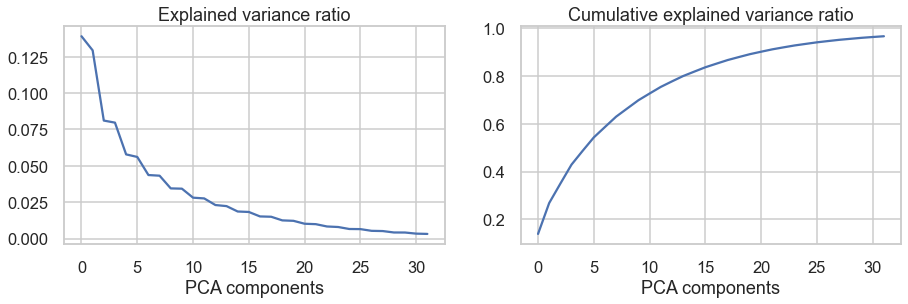

In [27]:
pca_input = []
for yi in y:
    pca_input.extend(yi[:, 0, :])
pca_input = np.array(pca_input)

pca = PCA(n_components=32, whiten=False)
pca_output = pca.fit_transform(pca_input)


fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_title("Explained variance ratio")
ax[0].set_xlabel("PCA components")

ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_title("Cumulative explained variance ratio")
ax[1].set_xlabel("PCA components")

plt.show()